###testing

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.io import wavfile as wav
import scipy
import scipy.signal.windows as win

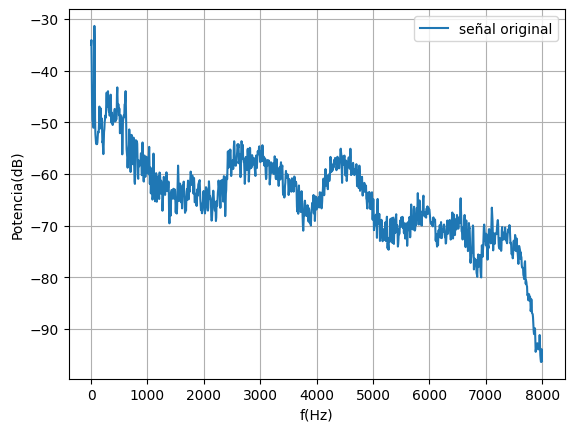

In [4]:


Fc = 2e3
v_sound = 343  # [m/s]

# Distancia entre sensores
dist = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8, 9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

Fs, signals = wav.read('mtms-arrC1A.wav')

# Acondicionamiento de las señales
data = signals / np.max(signals)

data = np.swapaxes(data, 0, 1)  # Fila son canales, columnas son tiempo

a, b = plt.mlab.psd(data[1], Fs=16000, NFFT=data[0].size//200)
plt.plot(b,10*np.log10(a), label='señal original')
plt.xlabel('f(Hz)')
plt.ylabel('Potencia(dB)')
#plt.ylim(-60, -20)
plt.legend()
plt.grid()

plt.show()

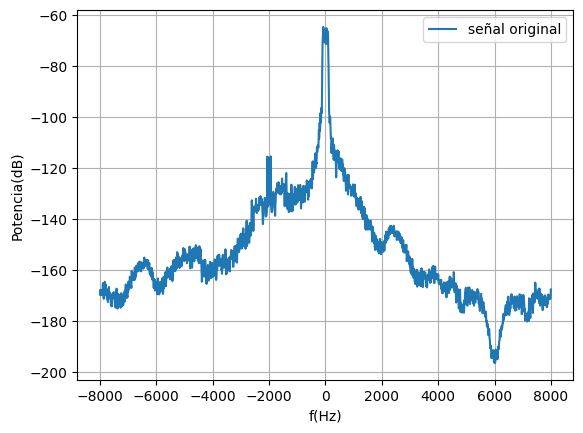

In [5]:
data_filt = np.zeros(np.shape(data), dtype=np.complex_)
exp_demod = np.exp(-2j * np.pi * Fc / Fs * np.arange(len(data[0]))) #esto es un corrimiento en frecuencia de 2000hz

for i, val in enumerate(data):
    samples_demod = exp_demod * data[i]
    #samples_filt = samples_demod

    #Aplicar el filtro pasa bajos
    order = 1000
    cutoff_freq = 100 / (Fs / 2)
    b = signal.firwin(order + 1, cutoff_freq, window='bartlett')
    samples_filt = signal.lfilter(b, 1, samples_demod)

    data_filt[i] = samples_filt

a, b = plt.mlab.psd(data_filt[1], Fs=16000, NFFT=data[0].size//200)
plt.plot(b,10*np.log10(a), label='señal original')
plt.xlabel('f(Hz)')
plt.ylabel('Potencia(dB)')
#plt.ylim(-60, -20)
plt.legend()
plt.grid()

plt.show()

###notocar

In [6]:

Fs = 16e3
Fc = 2e3
v_sound = 343 # [m/s]
l = v_sound/Fc

# Distancia entre sensores
dist = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

rate, data = wav.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo

# Acondicionamiento de las señales
data = data / np.max(data)
#for d in data:
#    d -= np.mean(d)
def demod_lowpass(samples, Fc, Fs, order, B):
    exp_demod = np.exp(-2j*np.pi*Fc/Fs* np.arange( len(samples) ))
    #exp_demod = 1
    samples_demod = exp_demod * samples

    a = 1
    b = signal.firwin(order+1, B, window='bartlett', fs=Fs)
    samples_filt = signal.lfilter(b, a, samples_demod)

    return samples_filt





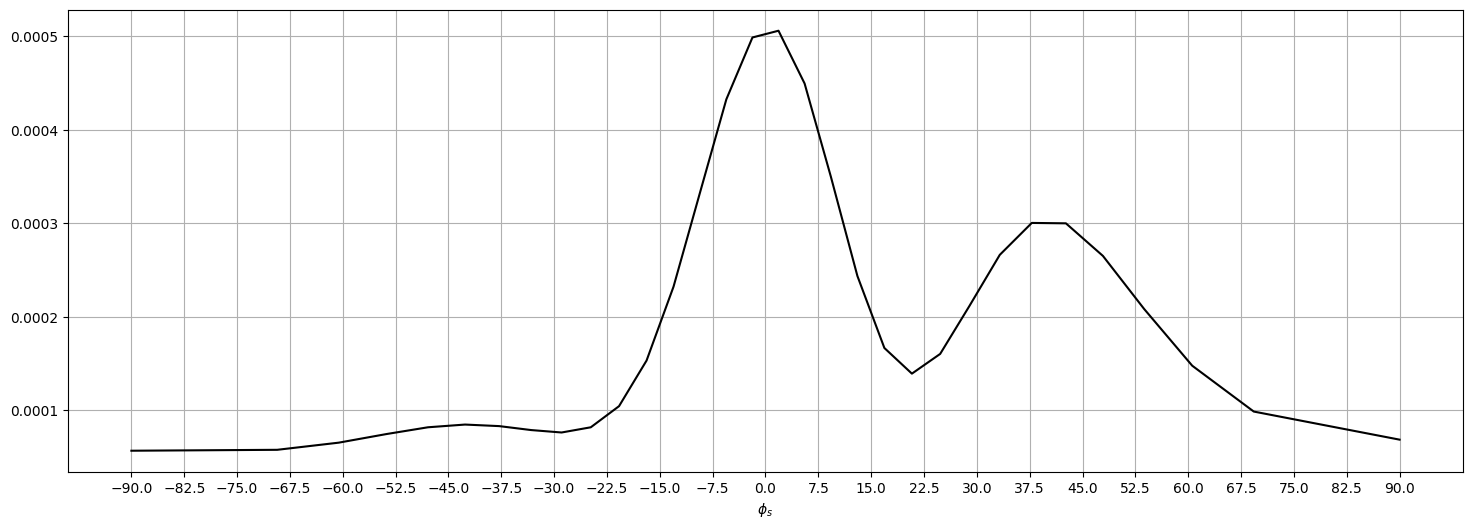

In [21]:
data_filt = np.zeros(np.shape(data), dtype=np.complex_)
for i, val in enumerate(data):
    data_filt[i] = demod_lowpass(data[i], Fc, Fs, 50, B=2000/50)

array_idx = 1

data_fft = np.zeros((32, data_filt.shape[1]), dtype=np.complex_)

for t in range(len(data_filt[0])):
    data_fft[:, t], _ = plt.mlab.psd(data_filt[subarray_sensors[array_idx] , t], 
                                            Fs=1, 
                                            NFFT=data_filt[subarray_sensors[array_idx] , t].size,
                                            pad_to=32,
                                            sides='twosided')
    
data_fft /=  data_filt.shape[1]

plt.figure(figsize=(18, 6))
phi_ax = 180/np.pi * np.arcsin(np.linspace(-1, 1, len(data_fft))) 
plt.plot(phi_ax , np.abs(data_fft).sum(axis=1), 'k')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('$\phi_s$')
plt.grid()
plt.show()

In [15]:
import numpy as np
from IPython.display import Audio

start = (16000*np.array([22, 25.8, 28.1, 31])).astype(int)
stop = (16000*np.array([23.1,25.8,28.1,31])).astype(int)

i_n_filt = data_filt[ subarray_sensors[array_idx]]
interference = np.zeros((9,0))
print(i_n_filt[:, start[1]:stop[1]].shape)
for i, item in enumerate(start):
    interference = np.concatenate((interference, i_n_filt[:, start[i]:stop[i]]), axis=1)

(9, 0)


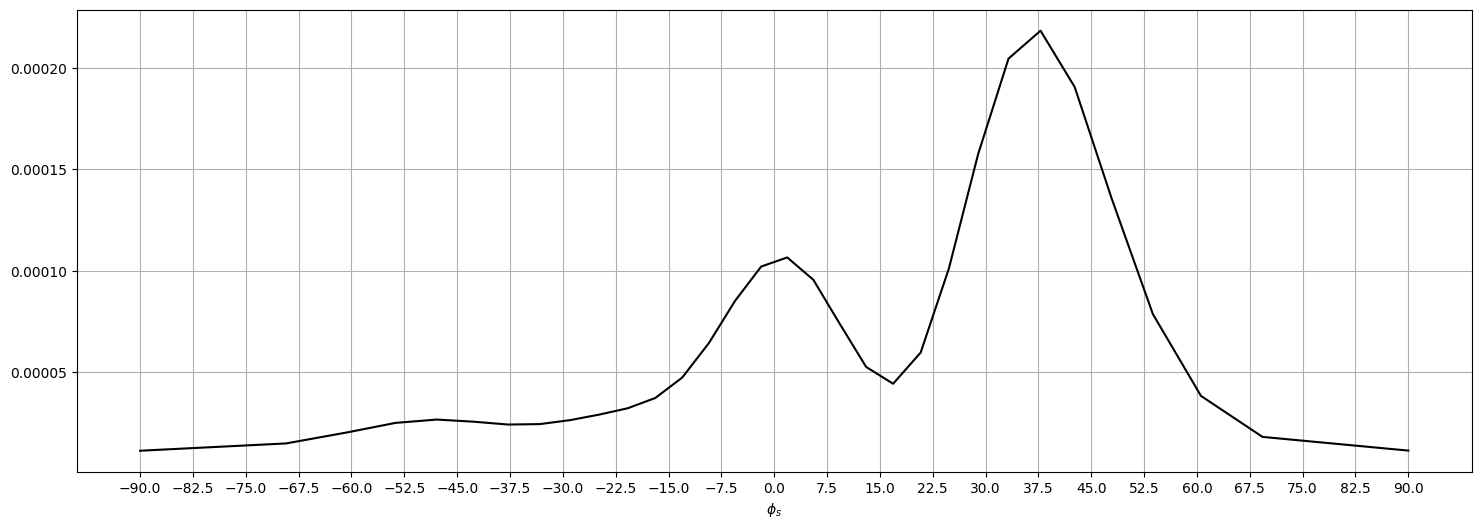

In [62]:
interference_fft = np.zeros((32, interference.shape[1]), dtype=np.complex_)

for t in range(len(interference[0])):
    interference_fft[:, t], _ = plt.mlab.psd(interference[: , t], 
                                            Fs=1, 
                                            NFFT=data_filt[: , t].size,
                                            pad_to=32,
                                            sides='twosided')
interference_fft /= len(interference[0])

plt.figure(figsize=(18, 6))
phi_ax = 180/np.pi * np.arcsin(np.linspace(-1, 1, len(interference_fft))) 
plt.plot(phi_ax , np.abs(interference_fft).sum(axis=1), 'k')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('$\phi_s$')
plt.grid()
plt.show()

In [60]:

#Creamos a la matriz Ri_n a partir de este segmento de grabación

n = interference.shape[0]
Ri_n = np.zeros((n, n), dtype=np.complex_)

for i in range( interference.shape[1] ):
    R = np.matmul( interference[:, i].reshape((n, 1)) , np.conj(interference[:, i]).reshape((1, n)) )
    Ri_n += R

Ri_n = Ri_n.transpose() / (interference.shape[1])

inv_Rin = np.linalg.inv(Ri_n)

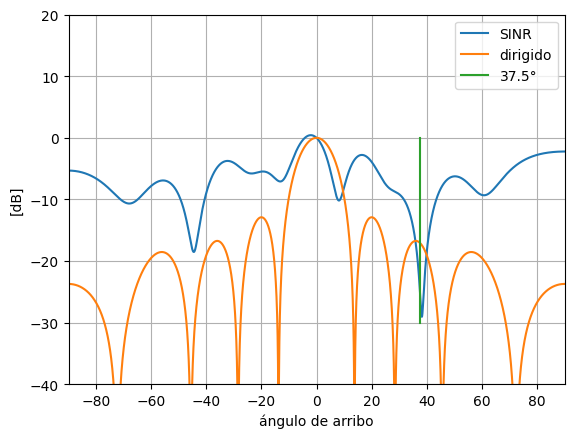

In [61]:
#Agarramos una parte de la grabación que no tenga al locutor

i_n_filt = data_filt[ subarray_sensors[array_idx]]

l = v_sound/Fc
d = dist[array_idx]
m = M[array_idx]


def response_vector(phi, m, d, l):
    return ( 1/np.sqrt(m) * np.exp(-2j * np.pi * d * np.sin(phi) / l * np.arange(m)) ).reshape((m, 1))

v_s = response_vector(0, m, d, l).reshape(m,1)
v_s_h = np.conj(v_s.transpose())

c_o = np.matmul(inv_Rin,v_s) / np.matmul( np.matmul(v_s_h, inv_Rin), v_s )[0][0]

C = []
for phi in np.linspace(-np.pi/2, np.pi/2, 5000):
    v = response_vector(phi, m, d, l)
    c_o_h = np.conj(c_o.transpose()) 
    C.append((np.dot(c_o_h, v)).flatten())

plt.plot(np.linspace(-90, 90, 5000), 10*np.log10(np.abs(C)**2), label='SINR')

C = []
for phi in np.linspace(-np.pi/2, np.pi/2, 5000):
    v = response_vector(phi, m, d, l)
    c = response_vector(0, m, d, l)
    c_h = np.conj(c.transpose()) 
    C_val = (np.dot(c_h, v)).flatten()
    C.append(C_val)


plt.plot(np.linspace(-90, 90, 5000), 10*np.log10(np.abs(C)**2), label='dirigido')
plt.xlim(-90,90);plt.grid()
plt.xlabel('ángulo de arribo')
plt.ylabel('[dB]')
plt.plot([37.5, 37.5], [-30, 0], label='37.5°')
plt.legend()
plt.ylim(-40,20)

plt.show()